# Taller 2.
## Oscar Eduardo Mejia 
### 201516790
***


In [243]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import string
import matplotlib.cm as cm
import os
from scipy import ndimage
from scipy.integrate import odeint

Populating the interactive namespace from numpy and matplotlib


Variables a Modificar

In [244]:
masa=152.0 # masa del Kart (kg)
ng=3.54 # Relación de Transmisión
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)
mu_c=1 #coeficiente de adherencia de las ruedas

# Variables de tiempo
t_in=0  
t_acel=60
t_fren=3
deltat=0.001


## No modificiar de aqui hacia abajo

A continuacion se definen parametros geometricos y fisicos del carro y algunas constantes relacionadas a los neumaticos y la carretera.  
Adicionalmente las funciones para el calculo de fuerza.
***
__Nota:__ Las graficas se encuentran al final del documento.

In [245]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
#dp=11.0 # Dientes del piñon
#dpl=39.0 # Dientes del plato
#ng=dpl/dp # Relación de Transmisión
ng=3.54
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
#masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)
illTotal=2*illd+illd*2
#paso=7.62 #(mm)
#rpim= paso*(0.6+(1/tan(180/dp))) # Radio Piñon (mm)
#rplam=paso*(0.6+(1/tan(180/dpl))) # Radio Plato (mm)
#rpi= rpim/1000 #Radio Piñon (m)
#rpla= rplam/1000 #Radio Plato (m)
rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
#a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
#l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
#h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)
TT=[]

In [246]:
def arrastre(Vx):
    return (1/2)*(rho)*af*cd*(Vx+0)**2

In [247]:
def traccion(ax,Fg,Fw,Fr):
    #eturn masa*ax+Fw+Fr
    return 

In [248]:
def rodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    return wr*fr*cos(theta)

In [249]:
def torquemotor(omega ):
    T=(4.90075-(4.15875*10**(-7))*(omega-771.889)**2)
    return T

In [250]:
def vangularmotor(vx):
    a=(vx*ng)/refc
    if a.any()>523.6:
        a=523.6
    TT.append(a)     
    return a # (rad/s)

In [251]:
masaEquivalente=((illTotal)+(ieje)+(ii*ng**2))/refc**2

In [252]:
def aceleracion(vx,t0):
    xx,v=vx
    ax=acel[len(acel)-1]
    a=(torquemotor(vangularmotor(vx)*60/(2*np.pi))*ng*etaf)/refc-rodadura(vx,ax)-arrastre(vx)
    a=a/(masaEquivalente+masa)
    acel.append(a)
    return a

In [253]:
def posicion(vt,lista,t): 
    for i,p in enumerate(t):
        if(i>0):
            x=(p-t[i-1])*(vt[i]+vt[i-1])/2
            x=lista[i-1]+x
            lista.append(x)

In [254]:
# condiciones iniciales
x_0=0
v_0=0
a_0=0
c_ini = [x_0,v_0]
t=np.arange(t_in,t_acel,deltat)

In [255]:
    acel=[]
    vel=[]
    pos=[]
   
    pos.append(x_0) 
    v=v_0
    a=a_0
    acel.append(a)
    vel.append(v)


In [256]:
 sol = odeint(aceleracion,c_ini,t)
 vel=sol[:,1]
 posicion(sol[:,1],pos,t)
 
 

In [257]:
def frenado(vx,t0):     
    xx,v=vx    
    vel2.append(v)
    f_d=mu_c*(w/l)*(l-a+h*mu_c)
    f_t=mu_c*(w/l)*(a+h*mu_c)
    ax=max(acel2[len(acel2)-1])
    if v<0 :
        af=[0,0]
    else:
        af=-f_d-f_t-rodadura(vx,ax)-arrastre(vx)
        af=af/(masaEquivalente+masa)
    acel2.append(af) 
    return af

In [258]:
t2=np.arange(t_in,t_fren,deltat)
x_f=max(pos)
v_f=max(vel)
pos2=[]
pos2.append(x_f)
vel2=[]
acel2=[]
acel2.append(acel[len(acel)-1])
c_ini2=[x_f,v_f]

In [259]:
sol2 = odeint(frenado,c_ini2,t2)
posicion(sol2[:,1],pos2,t2)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


## Graficas Para aceleración

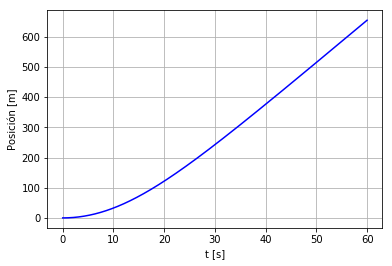

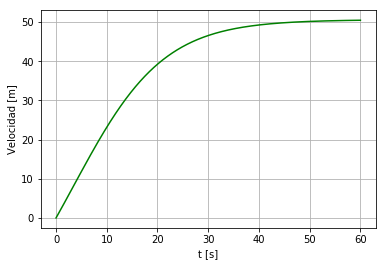

In [260]:
plt.plot(t, pos, 'b')
plt.legend(loc='best')
plt.xlabel('t [s]')
plt.ylabel('Posición [m]')
plt.grid()
plt.show()
plt.figure()
plt.plot(t, sol[:, 1]*3.6, 'g')
plt.legend(loc='best')
plt.xlabel('t [s]')
plt.ylabel('Velocidad [m]')
plt.grid()
plt.show()

## Graficas de frenado

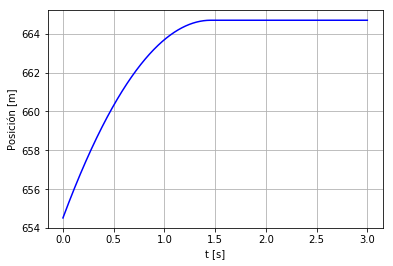

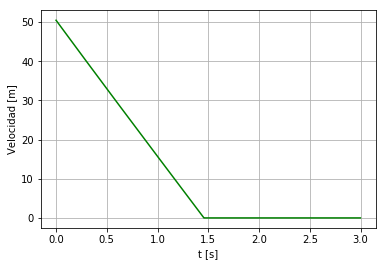

In [261]:
plt.plot(t2,pos2, 'b')
plt.legend(loc='best')
plt.xlabel('t [s]')
plt.ylabel('Posición [m]')
plt.grid()
plt.show()

plt.figure()
plt.plot(t2,sol2[:,1]*3.6, 'g')
plt.legend(loc='best')
plt.xlabel('t [s]')
plt.ylabel('Velocidad [m]')
plt.grid()
plt.show()

*Datos resumidos de la aceleración*

In [270]:
Velmax=max(sol[:,1])
dist_acel= 0
u=0;
for i in range(0,len(sol)):
    if Velmax==sol[i,1]:
        u=i
        dist_acel=pos[i]  
t_max=t[u]
print("La velocidad maxima es: %.2f m/s esta es alcanzada en un tiempo de: %.2f s. En ese tiempo recorre una distancia de:  %.2f m" % (Velmax,t_max,dist_acel))

La velocidad maxima es: 14.02 m/s esta es alcanzada en un tiempo de: 60.00 s. En ese tiempo recorre una distancia de:  654.52 m


*Datos resumidos de la freno*

In [271]:
Velmin=max(sol2[:,1])
dist_fren=max(pos2)-max(pos)
b=1265
for i,v in enumerate(sol2[:,1]):
    #print(v,i)
    if ((v>0)&(v>1e-5)):        
       b=i
t_max=t2[b]
print("La velocidad inicial es: %.2f m/s esta es alcanzada en un tiempo de: %.2f s. En ese tiempo recorre una distancia de: %.2f m" % (Velmax,t_max,dist_acel))

La velocidad inicial es: 14.02 m/s esta es alcanzada en un tiempo de: 1.46 s. En ese tiempo recorre una distancia de: 654.52 m
